In [1]:
#Written by Roc Chow, March 2020

In [2]:
#import libraries
import pandas as pd
import numpy as np
import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# read all csv files under the same directory
def readallcsv():
    allcsv = glob.glob("./*.csv")
    print("The following DataFrame will be created: ")
    for f in allcsv:
        print(f.split('.')[1][1:])
        globals()[f.split('.')[1][1:]] = pd.read_csv(f)


In [4]:
readallcsv()

The following DataFrame will be created: 
calendar
sales_train_validation
sample_submission
sell_prices


In [5]:
# Dataframe preparation

# use melt to aggregate d1-d_1913 to d column with count as demand
sales_train_validation_melt = pd.melt(sales_train_validation, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='demand')
# extend d column to d_num
sales_train_validation_melt['d_num'] = sales_train_validation_melt.d.str.split('_', n=1, expand=True)[1].astype(int)

# reduce the dataframe size to start from Day1000(to avoid memory error), later can adjust to earlier day if permitted
#sales_train_validation_melt_1000 = sales_train_validation_melt[sales_train_validation_melt.d_num > 999]

# bringing in calendar dataframe joining on d column
sales_cal_join = pd.merge(sales_train_validation_melt, calendar, on='d')

# joining price into the dataframe
#sales_cal_price_join = pd.merge(sales_cal_join, sell_prices, on=['store_id','item_id', 'wm_yr_wk'] )

<h1>Facebook Prophet</h1>
    Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

Prophet is open source software released by Facebook’s Core Data Science team. 
Source and more info:    https://facebook.github.io/prophet/

In [6]:
prophet_df = sales_cal_join[['date', 'store_id','dept_id','item_id','demand']]

In [7]:
from fbprophet import Prophet
def run_prophet(timeserie):
    model = Prophet(yearly_seasonality=True,daily_seasonality=False)
    model.fit(timeserie)
    forecast = model.make_future_dataframe(periods=28*2, include_history=False)
    forecast = model.predict(forecast)
    model.plot(forecast)
    return forecast

Utilizing more CPU power<br>
https://medium.com/spikelab/forecasting-multiples-time-series-using-prophet-in-parallel-2515abd1a245

HOBBIES_1
HOBBIES_2
HOUSEHOLD_1
Wall time: 1min 32s


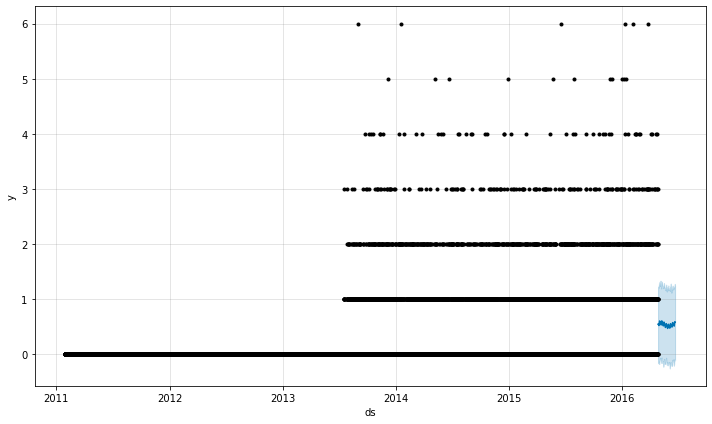

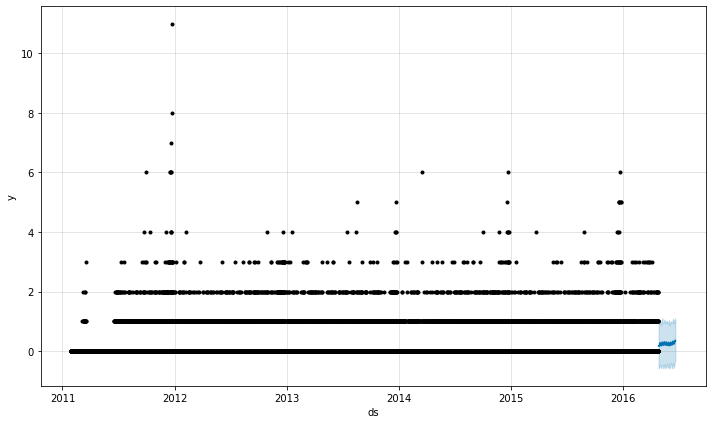

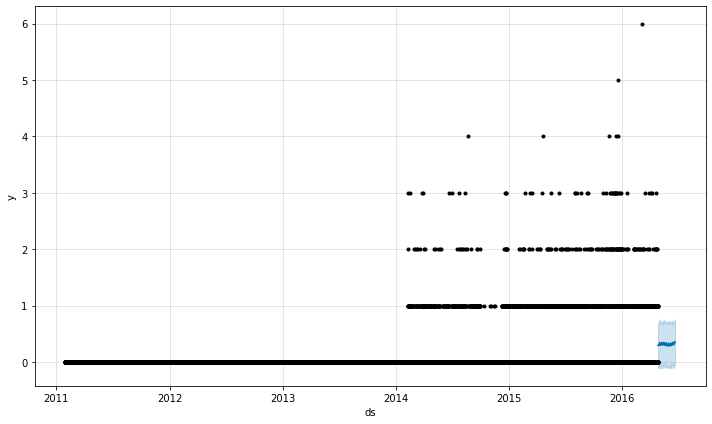

In [11]:
%%time
# Run 3 items and visualize the predictions
item_list = prophet_df.item_id.unique()
for i in np.arange(3):
    f = run_prophet(prophet_df[prophet_df['item_id']==item_list[i]][['date','demand']].rename(columns={"date": "ds", "demand": "y"}))
    print(dept_list[i])
    i+=1

In [9]:
# running prophet's own validation on the predicting the first item
from fbprophet.diagnostics import cross_validation
m = Prophet()
#item_list = prophet_df.item_id.unique()
df = prophet_df[prophet_df['item_id']==item_list[0]][['date','demand']].rename(columns={"date": "ds", "demand": "y"})
m.fit(df)
df_cv = cross_validation(m, initial='700 days', period='30 days', horizon = '5 days')
df_cv.head(10)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 41 forecasts with cutoffs between 2013-01-05 00:00:00 and 2016-04-19 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2013-01-06,0.0,-1.383180e-09,1.281863e-09,0,2013-01-05
1,2013-01-06,0.0,-1.364313e-09,1.334024e-09,0,2013-01-05
2,2013-01-06,0.0,-1.253082e-09,1.156126e-09,0,2013-01-05
3,2013-01-06,0.0,-1.253078e-09,1.287276e-09,0,2013-01-05
4,2013-01-06,0.0,-1.355165e-09,1.235058e-09,0,2013-01-05
5,2013-01-06,0.0,-1.261872e-09,1.340726e-09,0,2013-01-05
6,2013-01-06,0.0,-1.267850e-09,1.311511e-09,0,2013-01-05
7,2013-01-06,0.0,-1.224986e-09,1.266914e-09,0,2013-01-05
8,2013-01-06,0.0,-1.366099e-09,1.248221e-09,0,2013-01-05
9,2013-01-06,0.0,-1.319646e-09,1.247009e-09,0,2013-01-05


In [10]:
# review the valiation results
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

INFO:fbprophet:Skipping MAPE because y close to 0
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning:

Invalid value encountered in median



,horizon,mse,rmse,mae,mdape,coverage
0,1 days,0.506257,0.711517,0.490938,NaN,0.678049
1,2 days,0.557150,0.746425,0.511520,NaN,0.653659
2,3 days,0.579759,0.761419,0.509522,NaN,0.678049
3,4 days,0.482098,0.694333,0.488583,NaN,0.673171
4,5 days,0.438924,0.662513,0.467430,NaN,0.690244


The result is quite amazing.

To do: include holidays